In [102]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import numpy as np
import torchdata.datapipes as dp
import boto3
import os
import skimage
import PIL.Image
import json

In [2]:
def download_from_s3(bucket: str, remote_path: str, local_path: str, s3_client=None):
    if not s3_client:
        s3_client = boto3.client("s3")
    s3_client.download_file(bucket, remote_path, local_path)


def split_bucket_from_path(x: str):
    return "".join(x.split("/")[2:3]), "/".join(x.split("/")[3:])


def combine_bands(arrays: list[np.array], max_res=(120, 120)):
    """Combines bands into one array, upscaling each band to max_res.

    Args:
        arrays (list): list of bands
        max_res (tuple, optional): Max height & width to resize bands to. Defaults to (120, 120).

    Returns:
        np.array: Concatenated & resized bands.
    """
    result = np.zeros(shape=(*max_res, len(arrays)))
    for i, array in enumerate(arrays):
        assert array.shape[0] <= max_res[0]
        assert array.shape[1] <= max_res[1]
        result[:, :, i] = cv2.resize(array, dsize=max_res)
    return result

In [3]:
folder = "S2A_MSIL2A_20170613T101031_14_65/"
bucketname = f"s3://mi4people-soil-project/BigEarthNet-v1.0/{folder}"
pipe = dp.iter.IterableWrapper([bucketname])
pipe = pipe.list_files_by_fsspec()

In [4]:
tifs = [x for x in pipe if ".tif" in x]
for tif in tifs:
    bucket, remote = split_bucket_from_path(tif)
    file = tif.split("/")[-1]
    if not os.path.isdir(
        f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
    ):
        os.mkdir(
            f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
        )
    local = (
        f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
        + file
    )
    download_from_s3(bucket=bucket, remote_path=remote, local_path=local)

In [5]:
tif_dir = f"/home/philip/Projects/MI4People/MI4People_soil_quality/data/raw/bigearth_data/{folder}"
local_tifs = [os.path.join(tif_dir, x) for x in os.listdir(tif_dir)]
imgs = [skimage.io.imread(path) for path in local_tifs]
bands = [tif.split("_")[-1].split(".")[0] for tif in local_tifs]
resized = combine_bands(imgs)

In [104]:
img_pipe = dp.iter.IterableWrapper(
    [f"s3://mi4people-soil-project/BigEarthNet-v1.0/{folder}"]
)
img_pipe = img_pipe.list_files_by_fsspec()
img_pipe = img_pipe.filter(filter_fn=lambda x: x.endswith(".tif"))
img_pipe = img_pipe.open_files_by_fsspec(mode="rb")
img_pipe = img_pipe.map(lambda x: PIL.Image.open(x[1]))

gt_pipe = dp.iter.IterableWrapper(
    [f"s3://mi4people-soil-project/BigEarthNet-v1.0/{folder}"]
)
gt_pipe = gt_pipe.list_files_by_fsspec()
gt_pipe = gt_pipe.filter(filter_fn=lambda x: x.endswith(".json"))
gt_pipe = gt_pipe.open_files_by_fsspec()
gt_pipe = gt_pipe.map(lambda x: json.loads(x[1].read())["labels"])


gt_list = [x for x in gt_pipe]
print(gt_list)
img_list = [x for x in img_pipe]

/home/philip/miniconda3/envs/mi4p/lib/python3.10/site-packages/torch/utils/data/datapipes/utils/common.py:143: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


[['Land principally occupied by agriculture, with significant areas of natural vegetation', 'Coniferous forest', 'Mixed forest', 'Sea and ocean']]


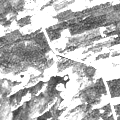

In [85]:
np.array(img_list[1]).shape
img_list[1].show()

In [27]:
def get_first_n_pcs(img: np.array, num_components: int):
    """Perform PCA on a single image and return principle components which make up the most variance.

    Args:
        img (np.array): Original image of shape (h, w, num_bands).
        num_components (int): Desired number of components to be returned.

    Returns:
        np.array: Components with shape (h, w, num_components).
    """
    # Convert 2d bands into 1-d arrays
    bands_vectorized = np.zeros(
        shape=(resized.shape[0] * resized.shape[1], resized.shape[2])
    )
    for i in range(img.shape[-1]):
        flattened_band = img[:, :, i].flatten()
        flattened_band_standard = (
            flattened_band - flattened_band.mean()
        ) / flattened_band.std()
        bands_vectorized[:, i] = flattened_band_standard

    cov = np.cov(bands_vectorized.transpose())
    eig_val, eig_vec = np.linalg.eig(cov)

    # Ordering Eigen values and vectors
    order = eig_val.argsort()[::-1]
    eig_val = eig_val[order]
    eig_vec = eig_vec[:, order]

    # Projecting data on Eigen vector directions resulting in Principal Components
    pcs = np.matmul(bands_vectorized, eig_vec)

    # Rearranging 1-d arrays to 2-d arrays of image size
    PC_2d = np.zeros((img.shape[0], img.shape[1], num_components))
    for i in range(num_components):
        PC_2d[:, :, i] = pcs[:, i].reshape(-1, img.shape[1])

    # normalizing between 0 to 255
    PC_2d_Norm = np.zeros((img.shape[0], img.shape[1], num_components))
    for i in range(num_components):
        PC_2d_Norm[:, :, i] = cv2.normalize(
            PC_2d[:, :, i], np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX
        )

    # fig,axes = plt.subplots(3,4,figsize=(50,23),sharex='all',
    #                         sharey='all')
    # fig.subplots_adjust(wspace=0.1, hspace=0.15)
    # fig.suptitle('Intensities of Principal Components ', fontsize=30)

    # axes = axes.ravel()
    # for i in range(num_components):
    #     axes[i].imshow(PC_2d_Norm[:,:,i],cmap='gray', vmin=0, vmax=255)
    #     axes[i].set_title('PC '+str(i+1),fontsize=25)
    #     axes[i].axis('off')
    # fig.delaxes(axes[-1])
    return PC_2d_Norm[:, :, : num_components + 1]

In [28]:
get_first_n_pcs(resized, 3).shape

(120, 120, 3)